# Visualization of the Titanic data to look for obvious features of import

## Some basic setup first

In [3]:
# Imprts
import matplotlib.pyplot as plt



In [4]:
# Pandas for constructing dataframes and plotting 
import pandas as pd
from pandas import Series, DataFrame

# math and plotting/stats tools
import numpy as np

import seaborn as sns


# Enable in-line plots and set the style for seaborn plots
%matplotlib inline
sns.set_style("whitegrid")

# Machine Learning Packages
from sklearn.ensemble import RandomForestClassifier

# Read in training and testing data into DataFrames
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

In [5]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Horgan, Mr. John",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


This describe of the data is powerful.
* Note the count column -- we get a great idea of how complete each column is here.  
      -Age: While most columns have 891 entries, Age only has 714. We clearly need to fill in this missing data in order to do some of our tests (like random forest). 
* The unique column is also interesting to see where there are items that can only be certain values (such as Embarked, Sex)
 

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Note that the cabin also may have some interesting agregate information when we consider only the letter (assuming the room isn't telling as there are so many of them).  We may want to strip the cabin class out when doing analysis.

### Lets clean the Age

We'll replace any missing data in the Age column with the mean over the full dataset.

**NOTE**: Looking at the distribution of ages before and after this clean step, it's clearly *NOT* the thing to do. You end up with a massive spike near the mean (not median nor mode) of the distribution.  Instead I've opted to follow a proceedure that maps the overall distribution into the cleaned data. 

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We're going to go ahead and drop a few items because they likely have no correlation (they are random variables for each entry).

In [9]:
train_df = train_df.drop(['PassengerId', 'Name','Ticket'], axis=1)

## Visualization

### Embarkation

Let's take a look at what the statistics look like for where people Embarked. Note that Embarked is described (in the online documentation) to only have three possible values, Q, S, C. Also note that there are only 2 entries where Embarked isn't one of these three values.  Lets look at this.  Since there are only 2, let's go ahead and replace these with the most occuring value of Embark

In [10]:
train_df[train_df["Embarked"].isnull() == True]
max = 0
maxval = None

unique_embarks = train_df["Embarked"][train_df["Embarked"].isnull() == False].unique()
for val in unique_embarks:
    nsubset = len(train_df[train_df["Embarked"] == "S"])
    if nsubset > max:
        max = nsubset
        maxval = val
maxval

'S'

So we will replace those missing values with 'S'

In [11]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")

Make some plots with SNS

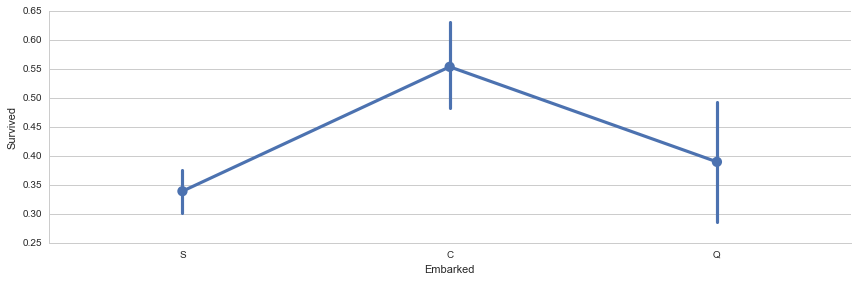

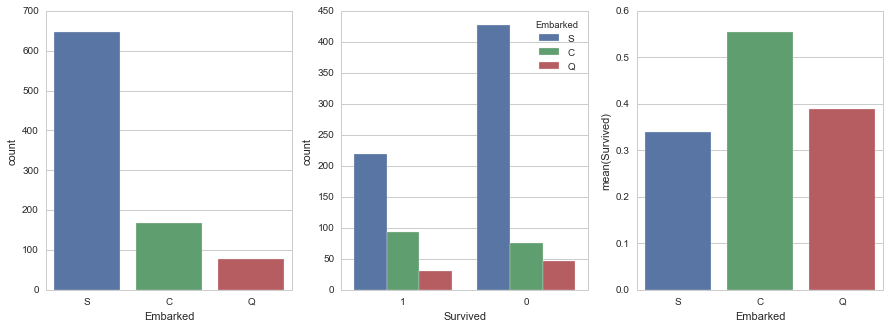

In [12]:
sns.factorplot(x="Embarked", y="Survived", data=train_df, size=4, aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Embarked', data=train_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)


A factor plot is a way to plot categorical plots in seaborn.  Here, it plots the mean "Survived" value (so N_alive/N_bin is the fraction that lived) for each of the three Embarked values. It sure looks like where someone got on could play a role in if they lived  -- the people that boarded in Cherbourg (C) survived at a several-sigma higher rate than Southampton (S qith Queenstown (Q) being somehwhere between the two. 

### Fare

How do the fare paid by people that lived and people that didn't compare?

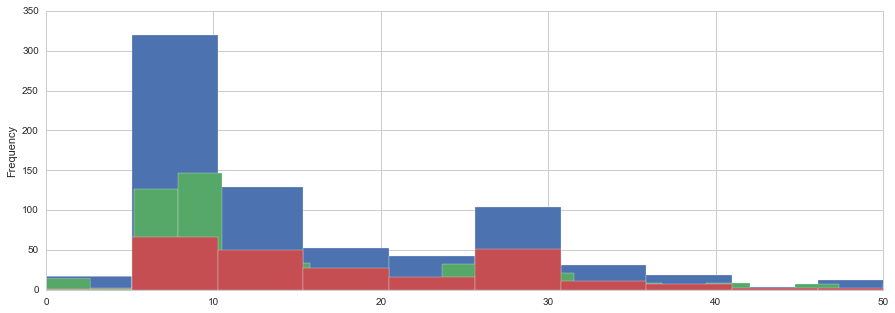

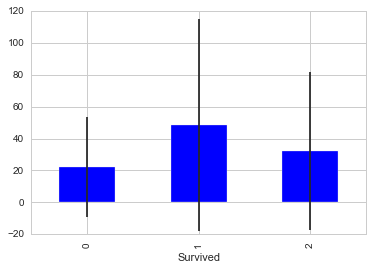

In [13]:
# Looking at Fares

# Fill any missing fares with the median
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

fare_dead = train_df["Fare"][train_df["Survived"] == 0]
fare_alive = train_df["Fare"][train_df["Survived"] == 1]
fare_all = train_df["Fare"]

# Create a DataFrame with the mean and standard deviation
avgFare = DataFrame([fare_dead.mean(), fare_alive.mean(), fare_all.mean()])
stdFare = DataFrame([fare_dead.std(), fare_alive.std(), fare_all.std()])

# Plot the histograms
fare_all.plot(kind="hist", figsize=(15, 5), bins=100, xlim=(0, 50))
fare_dead.plot(kind="hist", bins=100, xlim=(0, 50))
fare_alive.plot(kind="hist", bins=100, xlim=(0, 50))

avgFare.index.names = stdFare.index.names = ["Survived"]
avgFare.plot(yerr=stdFare, kind='bar', legend=False)

In this plot survived = 2 is the full data set.  Clearly the means of the distributions are different. Note also that the Std of the survivors is **much** higher than for the full data set and the dead passengers. This, at first glance, suggests that the high-end tail of the distribution is populated by living passengers (i.e. the more you paid, the higher the likelihood you survived).

In [14]:
train_sorted = train_df.sort_values("Fare")

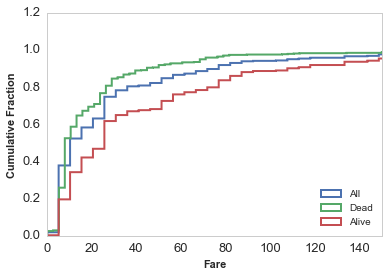

In [35]:
vals_alive = train_sorted["Fare"][train_sorted["Survived"]==1].values
vals_dead = train_sorted["Fare"][train_sorted["Survived"]==0].values
vals_all = train_sorted["Fare"].values

plt.xlim(0, 150)
plt.tick_params(axis='both', labelsize=13)
plt.xlabel("Fare",fontweight="bold")
plt.ylabel("Cumulative Fraction", fontweight="bold")
n, b, p = plt.hist(vals_all, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
n, b, p = plt.hist(vals_dead, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
n, b, p = plt.hist(vals_alive, 100, normed=1, histtype='step', cumulative=True, linewidth=2)
plt.legend(["All","Dead","Alive"], loc=4)
plt.grid(False)



Clearly the distributions of the Fares for each group are different.  A larger fraction of the "ALIVE" group paid more for their tickets.

### Now, let's look at Age

I mentioned before that my cleaning approach wasn't ideal.  I'm not sure this one is either, but I'm following what Relgabry did in his notebook to see what happens.

**Todo:** Try the following analysis with Age(NaN) = age.mean and see how that affects results

29.6991176471
30.2725903614


/Users/rcool/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


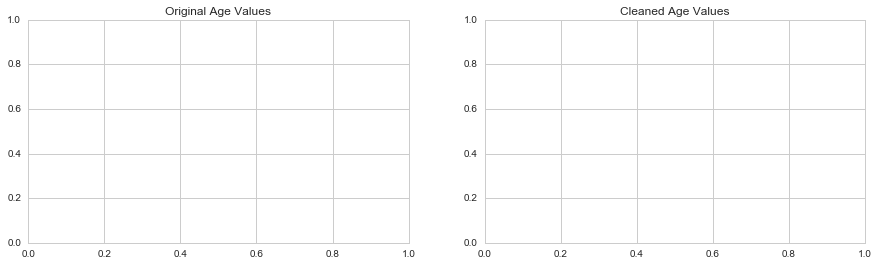

In [47]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
axis1.set_title("Original Age Values")
axis2.set_title('Cleaned Age Values')

avgAge = train_df["Age"].mean()
stdAge = train_df["Age"].std()
count_nan_age = train_df["Age"].isnull().sum()
count_nan_test = test_df["Age"].isnull().sum()

print(avgAge)
print(test_df["Age"].mean())


#Rather than set the age to the mean, we set the age to a random number (uniform) between age+/-std. 
randAge = np.random.randint(avgAge-stdAge, avgAge+stdAge, size=count_nan_age)
train_df["Age"][np.isnan(train_df["Age"])] = randAge

#While we're here, we should clean the test data, because we will need an Age there
test_randAge = np.random.randint(avgAge-stdAge, avgAge+stdAge, size=count_nan_test)
